# Model comparison on Fashion MNIST dataset

A custom CNN and a pre-trained model will be tested to compare their performance

In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models

In [2]:
import sys
sys.path.append("../scripts")

from train_utils import train_and_validate
from test_model import test_model

### Define data transformations and import the dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
data_dir = '../data'

train_data = datasets.FashionMNIST(data_dir, download=True, train=True, transform=transform)
test_data = datasets.FashionMNIST(data_dir, download=True, train=False, transform=transform)

In [5]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Creating the Validation Set

In [6]:
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, valid_data = torch.utils.data.random_split(train_data, [train_size, val_size])

### Data augmentation

In [7]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data.dataset.transform = train_transform

### Data loader

In [8]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

# Model Training

Defining two models, training them on the training set and validating them on the validation set.

## Custom CNN

Definition of a customised architecture.

In [9]:
class CustomCNN(nn.Module):
    def __init__(self, dropout_prob_conv=0.1, dropout_prob_fc=0.5):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout2d(dropout_prob_conv)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.dropout2 = nn.Dropout2d(dropout_prob_conv)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.dropout3 = nn.Dropout2d(dropout_prob_conv)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.dropout4 = nn.Dropout2d(dropout_prob_conv)
        self.relu4 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 7 * 7, 256)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)
        self.dropout_fc = nn.Dropout(dropout_prob_fc)

    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.dropout2(x)
        x = self.relu2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.dropout3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.dropout4(x)
        x = self.relu4(x)
        x = self.pool(x)
        x = x.view(-1, 256 * 7 * 7)
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

Train the model on the train set and evaluate the performance on the validation set

Epoch [1/100], Train Loss: 0.6977, Train Acc: 74.25%, Valid Loss: 0.4288, Valid Acc: 84.09%
Epoch [2/100], Train Loss: 0.4567, Train Acc: 83.34%, Valid Loss: 0.3395, Valid Acc: 87.51%
Epoch [3/100], Train Loss: 0.3980, Train Acc: 85.59%, Valid Loss: 0.3042, Valid Acc: 88.68%
Epoch [4/100], Train Loss: 0.3595, Train Acc: 86.80%, Valid Loss: 0.2874, Valid Acc: 89.33%
Epoch [5/100], Train Loss: 0.3286, Train Acc: 88.23%, Valid Loss: 0.2663, Valid Acc: 90.45%
Epoch [6/100], Train Loss: 0.3147, Train Acc: 88.72%, Valid Loss: 0.2509, Valid Acc: 90.99%
Epoch [7/100], Train Loss: 0.2999, Train Acc: 89.31%, Valid Loss: 0.2471, Valid Acc: 91.08%
Epoch [8/100], Train Loss: 0.2899, Train Acc: 89.54%, Valid Loss: 0.2314, Valid Acc: 91.36%
Epoch [9/100], Train Loss: 0.2754, Train Acc: 90.02%, Valid Loss: 0.2235, Valid Acc: 91.82%
Epoch [10/100], Train Loss: 0.2742, Train Acc: 90.18%, Valid Loss: 0.2233, Valid Acc: 91.85%
Epoch [11/100], Train Loss: 0.2687, Train Acc: 90.34%, Valid Loss: 0.2178, Vali

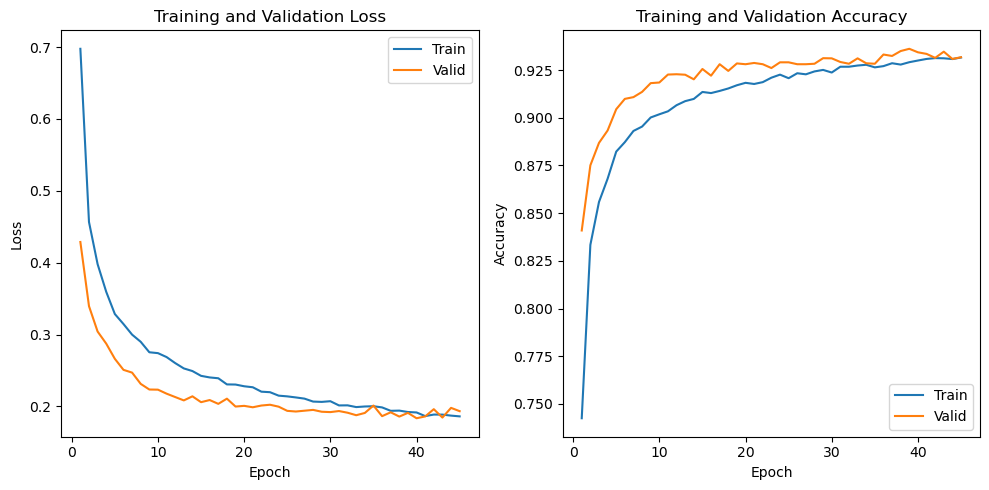

In [10]:
custom_cnn = CustomCNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_cnn.parameters(), lr=0.001)

train_and_validate(custom_cnn, train_loader, valid_loader, criterion, optimizer, num_epochs=100, patience=5, plot=True, seed=42)

Performance on the validation set

Test Accuracy: 93.26%
Precision: 0.9328
Recall: 0.9326
F1 Score: 0.9324


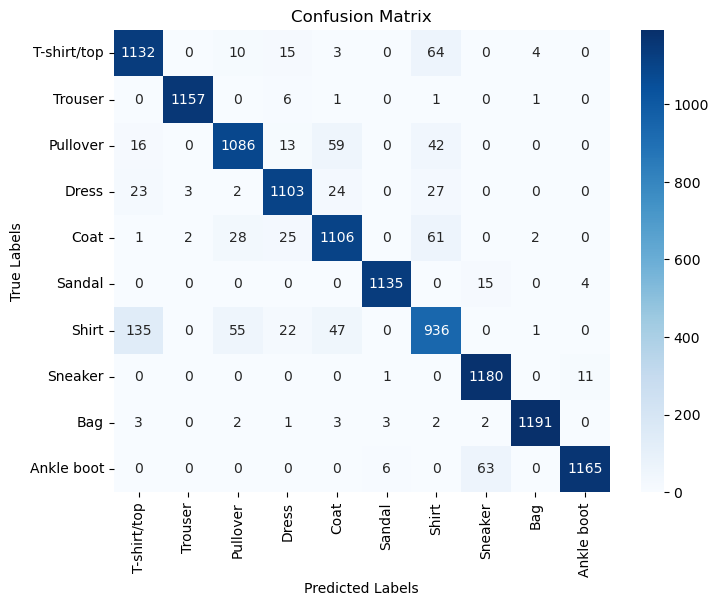

In [11]:
test_model(custom_cnn, valid_loader, classes, seed=42)

### CNN custom alternative version

Train the same model by changing the activation function

In [13]:
class CustomCNNLeaky(nn.Module):
    def __init__(self, dropout_prob_conv=0.1, dropout_prob_fc=0.5):
        super(CustomCNNLeaky, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout2d(dropout_prob_conv)
        self.leaky_relu1 = nn.LeakyReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.dropout2 = nn.Dropout2d(dropout_prob_conv)
        self.leaky_relu2 = nn.LeakyReLU()
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.dropout3 = nn.Dropout2d(dropout_prob_conv)
        self.leaky_relu3 = nn.LeakyReLU()
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.dropout4 = nn.Dropout2d(dropout_prob_conv)
        self.leaky_relu4 = nn.LeakyReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 7 * 7, 256)
        self.leaky_relu5 = nn.LeakyReLU()
        self.fc2 = nn.Linear(256, 10)
        self.dropout_fc = nn.Dropout(dropout_prob_fc)

    def forward(self, x):
        x = self.conv1(x)
        x = self.dropout1(x)
        x = self.leaky_relu1(x)
        x = self.conv2(x)
        x = self.dropout2(x)
        x = self.leaky_relu2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.dropout3(x)
        x = self.leaky_relu3(x)
        x = self.conv4(x)
        x = self.dropout4(x)
        x = self.leaky_relu4(x)
        x = self.pool(x)
        x = x.view(-1, 256 * 7 * 7)
        x = self.fc1(x)
        x = self.leaky_relu5(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

Epoch [1/100], Train Loss: 0.6716, Train Acc: 75.30%, Valid Loss: 0.4163, Valid Acc: 84.77%
Epoch [2/100], Train Loss: 0.4308, Train Acc: 84.11%, Valid Loss: 0.3291, Valid Acc: 87.99%
Epoch [3/100], Train Loss: 0.3702, Train Acc: 86.56%, Valid Loss: 0.2890, Valid Acc: 89.31%
Epoch [4/100], Train Loss: 0.3330, Train Acc: 87.76%, Valid Loss: 0.2708, Valid Acc: 90.08%
Epoch [5/100], Train Loss: 0.3106, Train Acc: 88.80%, Valid Loss: 0.2626, Valid Acc: 90.48%
Epoch [6/100], Train Loss: 0.2953, Train Acc: 89.27%, Valid Loss: 0.2444, Valid Acc: 91.16%
Epoch [7/100], Train Loss: 0.2783, Train Acc: 89.95%, Valid Loss: 0.2288, Valid Acc: 91.46%
Epoch [8/100], Train Loss: 0.2721, Train Acc: 90.09%, Valid Loss: 0.2293, Valid Acc: 91.66%
Epoch [9/100], Train Loss: 0.2586, Train Acc: 90.59%, Valid Loss: 0.2205, Valid Acc: 91.68%
Epoch [10/100], Train Loss: 0.2537, Train Acc: 90.62%, Valid Loss: 0.2304, Valid Acc: 91.64%
Epoch [11/100], Train Loss: 0.2493, Train Acc: 90.85%, Valid Loss: 0.2115, Vali

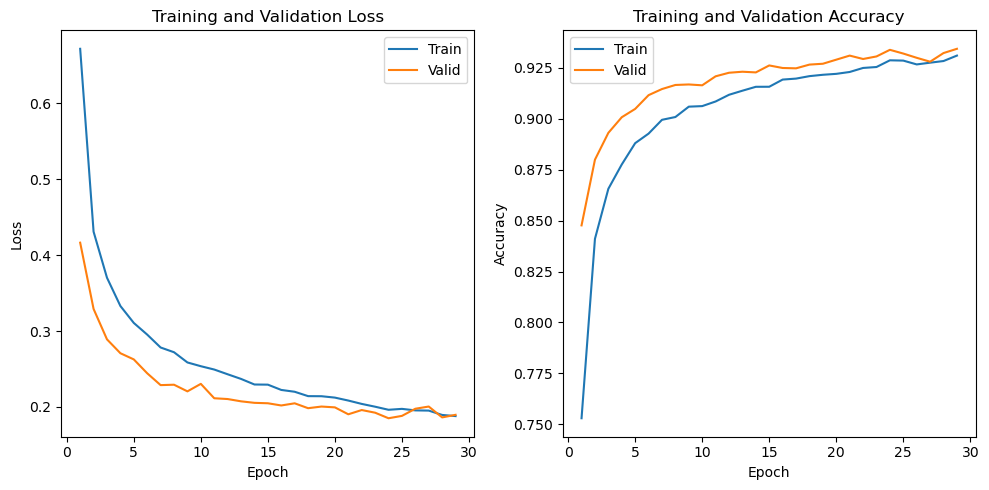

In [14]:
custom_cnn_leaky = CustomCNNLeaky()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_cnn_leaky.parameters(), lr=0.001)

train_and_validate(custom_cnn_leaky, train_loader, valid_loader, criterion, optimizer, num_epochs=100, patience=5, plot=True, seed=42)

Performance on the validation set

Test Accuracy: 93.35%
Precision: 0.9342
Recall: 0.9335
F1 Score: 0.9337


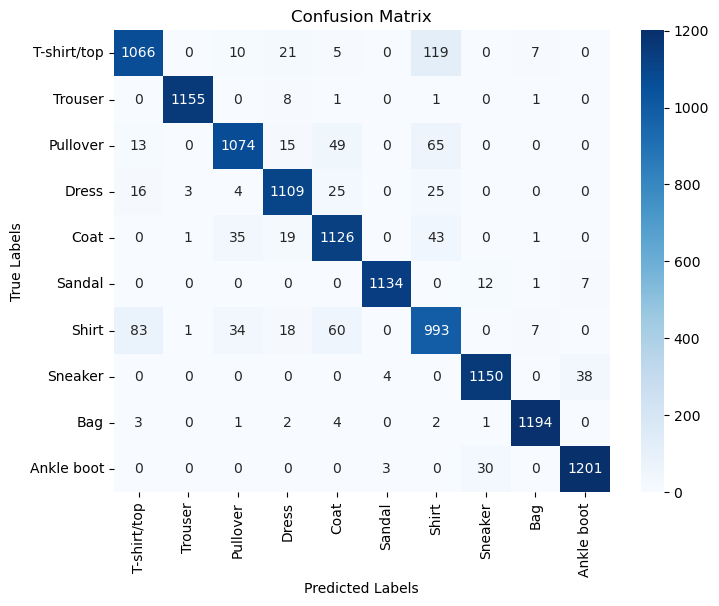

In [15]:
test_model(custom_cnn_leaky, valid_loader, classes, seed=42)

## Pre-trained model

Defined a ResNet neural network by changing its last layer

In [17]:
class ResNetGray(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetGray, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

Train set training

d:\anaconda3\envs\deepenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda3\envs\deepenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100], Train Loss: 0.6090, Train Acc: 78.04%, Valid Loss: 0.5220, Valid Acc: 81.62%
Epoch [2/100], Train Loss: 0.4408, Train Acc: 83.58%, Valid Loss: 0.3837, Valid Acc: 85.78%
Epoch [3/100], Train Loss: 0.3896, Train Acc: 85.55%, Valid Loss: 0.3383, Valid Acc: 87.38%
Epoch [4/100], Train Loss: 0.3583, Train Acc: 86.75%, Valid Loss: 0.3283, Valid Acc: 87.90%
Epoch [5/100], Train Loss: 0.3371, Train Acc: 87.65%, Valid Loss: 0.3551, Valid Acc: 86.52%
Epoch [6/100], Train Loss: 0.3175, Train Acc: 88.33%, Valid Loss: 0.3402, Valid Acc: 86.70%
Epoch [7/100], Train Loss: 0.3059, Train Acc: 88.62%, Valid Loss: 0.3037, Valid Acc: 88.86%
Epoch [8/100], Train Loss: 0.2963, Train Acc: 89.06%, Valid Loss: 0.2876, Valid Acc: 89.34%
Epoch [9/100], Train Loss: 0.2811, Train Acc: 89.52%, Valid Loss: 0.2917, Valid Acc: 88.83%
Epoch [10/100], Train Loss: 0.2710, Train Acc: 89.74%, Valid Loss: 0.2907, Valid Acc: 88.83%
Epoch [11/100], Train Loss: 0.2641, Train Acc: 90.19%, Valid Loss: 0.2659, Vali

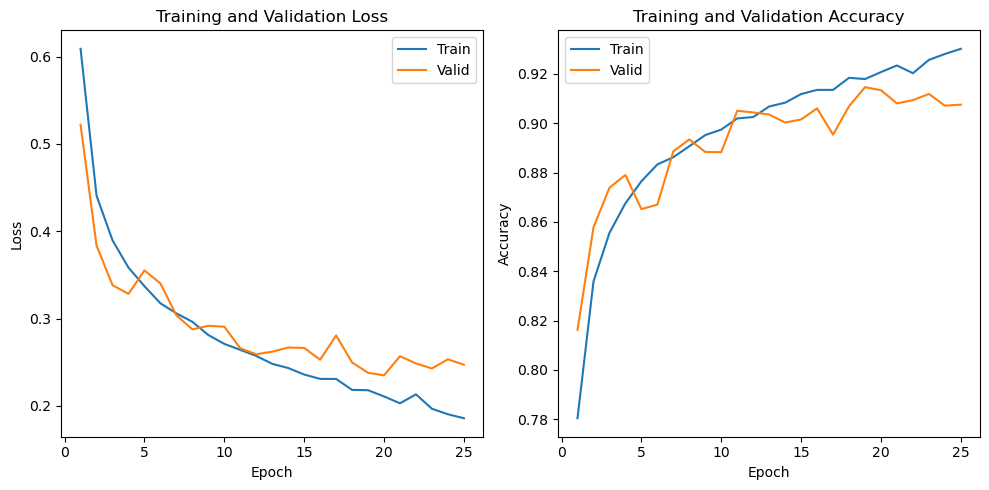

In [18]:
model_resnet = ResNetGray()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)

train_and_validate(model_resnet, train_loader, valid_loader, criterion, optimizer, num_epochs=100, patience=5, plot=True, seed=42)

Performance on the validation set

Test Accuracy: 90.99%
Precision: 0.9126
Recall: 0.9099
F1 Score: 0.9107


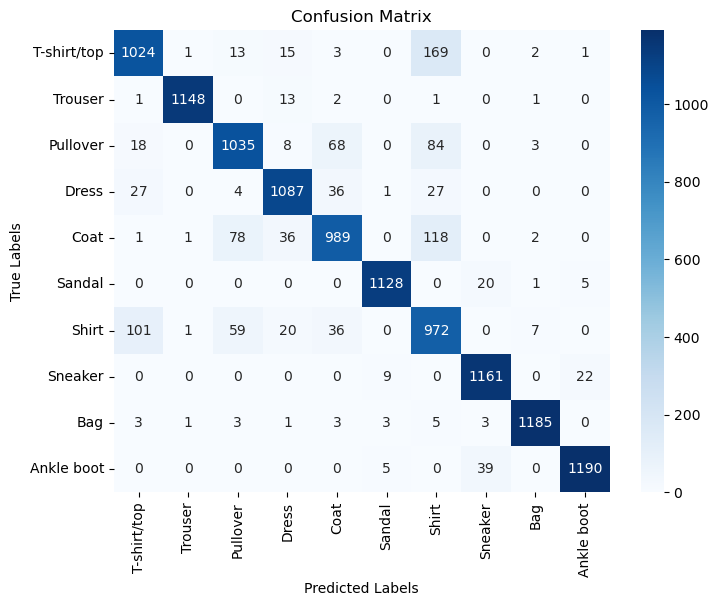

In [19]:
test_model(model_resnet, valid_loader, classes, seed=42)

# Model Testing

The two models are tested on the test set.

## CNN custom test

The version with Leaky ReLu was tested, which performed better on the Validation set.

Test Accuracy: 92.88%
Precision: 0.9295
Recall: 0.9288
F1 Score: 0.9290


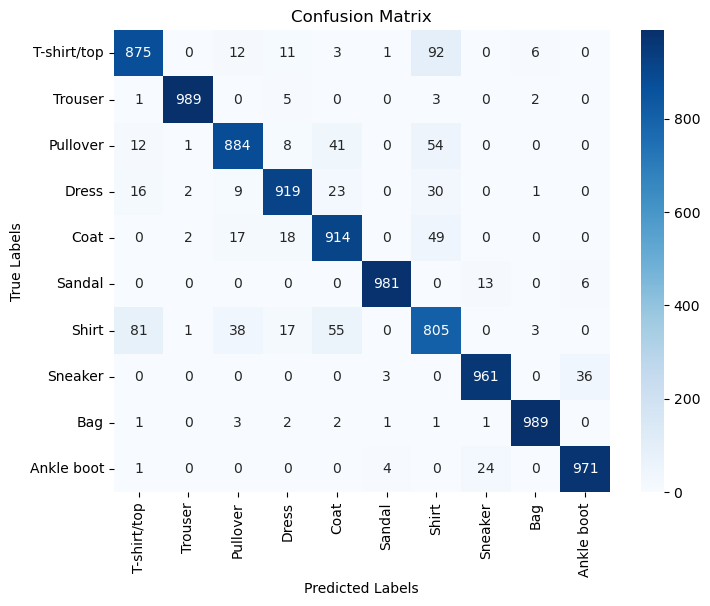

In [16]:
test_model(custom_cnn_leaky, test_loader, classes, seed=42)

## ResNet test

Test Accuracy: 90.91%
Precision: 0.9110
Recall: 0.9091
F1 Score: 0.9098


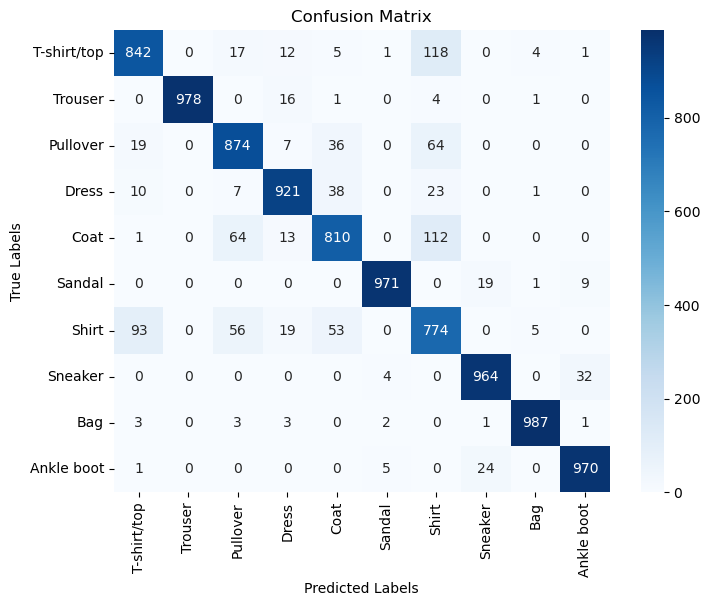

In [20]:
test_model(model_resnet, test_loader, classes, seed=42)

# Saving models

In [25]:
# Save the model
dir_models = '../models'
torch.save(custom_cnn_leaky.state_dict(), f'{dir_models}/custom_cnn_leaky.pth')
torch.save(model_resnet.state_dict(), f'{dir_models}/resnet_gray.pth')